Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (200000, 28, 28), (200000,))
('Validation set', (10000, 28, 28), (10000,))
('Test set', (10000, 28, 28), (10000,))


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (200000, 784), (200000, 10))
('Validation set', (10000, 784), (10000, 10))
('Test set', (10000, 784), (10000, 10))


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compue the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
  
    # Variables.
    weights = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + beta_regul * tf.nn.l2_loss(weights))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

******** beta = 0.000100
Initialized
L2 regularization(beta=0.00010) Test accuracy: 86.5%
******** beta = 0.000167
Initialized
L2 regularization(beta=0.00017) Test accuracy: 86.5%
******** beta = 0.000278
Initialized
L2 regularization(beta=0.00028) Test accuracy: 87.0%
******** beta = 0.000464
Initialized
L2 regularization(beta=0.00046) Test accuracy: 87.1%
******** beta = 0.000774
Initialized
L2 regularization(beta=0.00077) Test accuracy: 87.9%
******** beta = 0.001292
Initialized
L2 regularization(beta=0.00129) Test accuracy: 88.2%
******** beta = 0.002154
Initialized
L2 regularization(beta=0.00215) Test accuracy: 88.2%
******** beta = 0.003594
Initialized
L2 regularization(beta=0.00359) Test accuracy: 87.9%
******** beta = 0.005995
Initialized
L2 regularization(beta=0.00599) Test accuracy: 87.8%
******** beta = 0.010000
Initialized
L2 regularization(beta=0.01000) Test accuracy: 87.4%
Best beta=0.001292, accuracy=88.2%


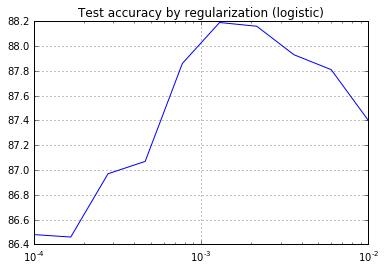

In [6]:
num_steps = 3001

betas = np.logspace(-4, -2, 10)
accuracys = []

import matplotlib.pyplot as plt
% matplotlib inline

for beta in betas:
    print('******** beta = %f'% beta)
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            _, l, predictions = session.run( [optimizer, loss, train_prediction], feed_dict=
                                            {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul: beta})
        print("L2 regularization(beta=%.5f) Test accuracy: %.1f%%" % (
            beta, accuracy(test_prediction.eval(), test_labels)))
        accuracys.append(accuracy(test_prediction.eval(), test_labels))
 
print('Best beta=%f, accuracy=%.1f%%' % (betas[np.argmax(accuracys)], max(accuracys)))
plt.semilogx(betas, accuracys)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [7]:
batch_size = 128
hidden_size = 1024
 
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32)
 
    # Variables.
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))
 
    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))
 
    # Training computation.
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    logits = tf.matmul(y1, W2) + b2
 
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
 
    loss = loss + tf_beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2))
 
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
 
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
 
    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    valid_logits = tf.matmul(y1_valid, W2) + b2
    valid_prediction = tf.nn.softmax(valid_logits)
 
    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    test_logits = tf.matmul(y1_test, W2) + b2
    test_prediction = tf.nn.softmax(test_logits)
 

******** beta = 0.000100
Initialized
L2 regularization(beta=0.00010) Test accuracy: 87.0%
******** beta = 0.000167
Initialized
L2 regularization(beta=0.00017) Test accuracy: 87.5%
******** beta = 0.000278
Initialized
L2 regularization(beta=0.00028) Test accuracy: 87.7%
******** beta = 0.000464
Initialized
L2 regularization(beta=0.00046) Test accuracy: 88.6%
******** beta = 0.000774
Initialized
L2 regularization(beta=0.00077) Test accuracy: 90.4%
******** beta = 0.001292
Initialized
L2 regularization(beta=0.00129) Test accuracy: 92.1%
******** beta = 0.002154
Initialized
L2 regularization(beta=0.00215) Test accuracy: 91.7%
******** beta = 0.003594
Initialized
L2 regularization(beta=0.00359) Test accuracy: 90.8%
******** beta = 0.005995
Initialized
L2 regularization(beta=0.00599) Test accuracy: 89.6%
******** beta = 0.010000
Initialized
L2 regularization(beta=0.01000) Test accuracy: 88.6%
Best beta=0.001292, accuracy=92.1%


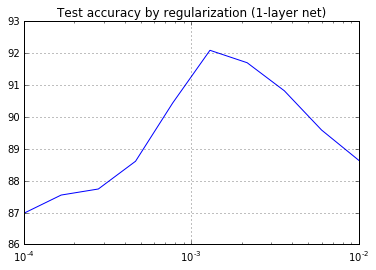

In [12]:
accuracys= []
for beta in betas:
    print('******** beta = %f'% beta)
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        print("L2 regularization(beta=%.5f) Test accuracy: %.1f%%" % ( beta, accuracy(test_prediction.eval(), test_labels)))
        accuracys.append(accuracy(test_prediction.eval(), test_labels))
 
print('Best beta=%f, accuracy=%.1f%%' % (betas[np.argmax(accuracys)], max(accuracys)))
plt.semilogx(betas, accuracys)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [13]:
batch_size = 128
hidden_size = 1024
 
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32)
 
    # Variables.
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))
 
    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))
 
    # Training computation.
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    y1 = tf.nn.dropout(y1, 0.5)  # Dropout
    logits = tf.matmul(y1, W2) + b2
 
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
 
    loss = loss + tf_beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2))
 
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
 
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
 
    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    valid_logits = tf.matmul(y1_valid, W2) + b2
    valid_prediction = tf.nn.softmax(valid_logits)
 
    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    test_logits = tf.matmul(y1_test, W2) + b2
    test_prediction = tf.nn.softmax(test_logits)
 
# Let's run it:
num_steps = 3001
 
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 0.001438}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Dropout Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 927.381653
Minibatch accuracy: 9.4%
Validation accuracy: 44.0%
Minibatch loss at step 500: 229.863480
Minibatch accuracy: 82.8%
Validation accuracy: 79.1%
Minibatch loss at step 1000: 114.225166
Minibatch accuracy: 78.9%
Validation accuracy: 80.2%
Minibatch loss at step 1500: 53.648960
Minibatch accuracy: 78.9%
Validation accuracy: 83.8%
Minibatch loss at step 2000: 25.517511
Minibatch accuracy: 82.0%
Validation accuracy: 86.1%
Minibatch loss at step 2500: 12.836279
Minibatch accuracy: 78.9%
Validation accuracy: 86.3%
Minibatch loss at step 3000: 6.684408
Minibatch accuracy: 76.6%
Validation accuracy: 87.1%
Dropout Test accuracy: 92.3%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [14]:
batch_size = 128
fc1_size = 4096
fc2_size = 2048
fc3_size = 128
 
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_beta = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)  # count the number of steps taken.
 
    # Variables.
    # stddev is very important!!!
    W1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, fc1_size], stddev=np.sqrt(2.0 / (image_size * image_size))))
    b1 = tf.Variable(tf.zeros([fc1_size]))
 
    W2 = tf.Variable(tf.truncated_normal([fc1_size, fc2_size], stddev=np.sqrt(2.0 / fc1_size)))
    b2 = tf.Variable(tf.zeros([fc2_size]))
 
    W3 = tf.Variable(tf.truncated_normal([fc2_size, fc3_size], stddev=np.sqrt(2.0 / fc2_size)))
    b3 = tf.Variable(tf.zeros([fc3_size]))
 
    W4 = tf.Variable(tf.truncated_normal([fc3_size, num_labels], stddev=np.sqrt(2.0 / fc3_size)))
    b4 = tf.Variable(tf.zeros([num_labels]))
 
    # Training computation.
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    # y1 = tf.nn.dropout(y1, 0.5)
 
    y2 = tf.nn.relu(tf.matmul(y1, W2) + b2)
    # y2 = tf.nn.dropout(y2, 0.5)
 
    y3 = tf.nn.relu(tf.matmul(y2, W3) + b3)
    # y3 = tf.nn.dropout(y3, 0.5)
 
    logits = tf.matmul(y3, W4) + b4
 
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
 
    loss = loss + tf_beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2) +
                             tf.nn.l2_loss(W3) + tf.nn.l2_loss(b3) + tf.nn.l2_loss(W4) + tf.nn.l2_loss(b4))
 
    # Optimizer
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.7, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
 
    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    y2_valid = tf.nn.relu(tf.matmul(y1_valid, W2) + b2)
    y3_valid = tf.nn.relu(tf.matmul(y2_valid, W3) + b3)
    valid_logits = tf.matmul(y3_valid, W4) + b4
    valid_prediction = tf.nn.softmax(valid_logits)
 
    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    y2_test = tf.nn.relu(tf.matmul(y1_test, W2) + b2)
    y3_test = tf.nn.relu(tf.matmul(y2_test, W3) + b3)
    test_logits = tf.matmul(y3_test, W4) + b4
    test_prediction = tf.nn.softmax(test_logits)
 
# Let's run it:
num_steps = 12001
 
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, tf_beta: 0.001438}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Final Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 9.546898
Minibatch accuracy: 10.9%
Validation accuracy: 15.2%
Minibatch loss at step 500: 3.864041
Minibatch accuracy: 90.6%
Validation accuracy: 87.2%
Minibatch loss at step 1000: 2.310104
Minibatch accuracy: 85.9%
Validation accuracy: 87.6%
Minibatch loss at step 1500: 1.494854
Minibatch accuracy: 88.3%
Validation accuracy: 88.5%
Minibatch loss at step 2000: 1.134554
Minibatch accuracy: 84.4%
Validation accuracy: 89.4%
Minibatch loss at step 2500: 0.942665
Minibatch accuracy: 87.5%
Validation accuracy: 89.2%
Minibatch loss at step 3000: 0.794093
Minibatch accuracy: 89.8%
Validation accuracy: 89.7%
Minibatch loss at step 3500: 0.842916
Minibatch accuracy: 85.2%
Validation accuracy: 90.6%
Minibatch loss at step 4000: 0.548736
Minibatch accuracy: 95.3%
Validation accuracy: 90.3%
Minibatch loss at step 4500: 0.660358
Minibatch accuracy: 89.1%
Validation accuracy: 90.7%
Minibatch loss at step 5000: 0.527748
Minibatch accuracy: 93.0%
Validation accurac